Dans ce notebook on fera l'étude et la mise en place d'un algorithmme d'aprentissage pour la prédictions de l'émissions de CO2 des bâtiments

# Import

In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.utils import resample

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score
import math

from sklearn.feature_selection import SelectFromModel

import shap

import lime
from lime import lime_tabular

import pickle

import warnings
warnings.filterwarnings('ignore')

In [ ]:
shap.initjs()

## Fonctions

In [ ]:
def ML(X_train, y_train, X_test, y_test, model):

  """
  Cette fonction renvoi les résultats des métriques avec les paramètres par défaut du modèle
  """
    
  model_gscv = model
  model_gscv.fit(X_train, y_train)

  best_par = model_gscv.get_params()

  y_pred_train = model_gscv.predict(X_train)
  R2_train = r2_score(y_train, y_pred_train)
  MAE_train = mean_absolute_error(y_train, y_pred_train)
  RMSE_train = math.sqrt(mean_squared_error(y_train, y_pred_train))

  y_pred_test = model_gscv.predict(X_test)

  R2_test = r2_score(y_test, y_pred_test)
  MAE_test = mean_absolute_error(y_test, y_pred_test)
  RMSE_test = math.sqrt(mean_squared_error(y_test, y_pred_test))

  performance_measure = R2_train, MAE_train, RMSE_train, R2_test, MAE_test, RMSE_test

  if str(model) == str(RandomForestRegressor()):
    
    return performance_measure, best_par

  return performance_measure

In [ ]:
def ML_GridSearchCV(X_train, y_train, X_test, y_test, model, param_grid):
  
  """
  
  Fonction qui permet d'optimisé ces modèles par le biais de gridsearchCV
  
  """
  model_gscv = GridSearchCV(model, param_grid, cv=5) 
  model_gscv.fit(X_train, y_train)

  #Meilleur estimator
  best_par = model_gscv.best_estimator_

  print(best_par)

  y_pred_train = model_gscv.predict(X_train)
  R2_train = r2_score(y_train, y_pred_train)
  MAE_train = mean_absolute_error(y_train, y_pred_train)
  RMSE_train = math.sqrt(mean_squared_error(y_train, y_pred_train))

  y_pred_test = model_gscv.predict(X_test)

  R2_test = r2_score(y_test, y_pred_test)
  MAE_test = mean_absolute_error(y_test, y_pred_test)
  RMSE_test = math.sqrt(mean_squared_error(y_test, y_pred_test))

  performance_measure = R2_train, MAE_train, RMSE_train, R2_test, MAE_test, RMSE_test
  
  if str(model) == str(RandomForestRegressor()) or str(model) == str(GradientBoostingRegressor()):
    feat_imp = model_gscv.best_estimator_.feature_importances_
    return performance_measure, best_par, feat_imp

  elif str(model) == str(linear_model.Lasso()) or str(model) == str(Ridge()):
    coefficients = model_gscv.best_estimator_.coef_
    importance = np.abs(coefficients)
    return performance_measure, best_par, importance

  elif str(model) == str(ElasticNet()) :
    coefficients = model_gscv.best_estimator_.coef_
    importance = np.abs(coefficients)
    return performance_measure, best_par, importance

  else:
    return performance_measure, best_par

##Dataset import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_EmissionsCO2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/OC Projet4/DonneEmissionsCO2Seatle.csv')

In [ ]:
#data_EmissionsCO2 = pd.read_csv('DonneEmissionsCO2Seatle.csv')

# Etape1: Features engeenering

In [ ]:
data_EmissionsCO2.shape

(1094, 29)

In [ ]:
data_EmissionsCO2.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,TotalGHGEmissions
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,88434,Hotel,Hotel,88434.0,None,0.0,None,0.0,60.0,249.98
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,295.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,759392,Hotel,Hotel,756493.0,None,0.0,None,0.0,43.0,2089.28
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,61320,Hotel,Hotel,61320.0,None,0.0,None,0.0,56.0,286.43
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,505.01


In [ ]:
data_EmissionsCO2.isna().sum()

OSEBuildingID                      0
DataYear                           0
BuildingType                       0
PrimaryPropertyType                0
PropertyName                       0
Address                            0
City                               0
State                              0
ZipCode                            0
TaxParcelIdentificationNumber      0
CouncilDistrictCode                0
Neighborhood                       0
Latitude                           0
Longitude                          0
YearBuilt                          0
NumberofBuildings                  0
NumberofFloors                     0
PropertyGFATotal                   0
PropertyGFAParking                 0
PropertyGFABuilding(s)             0
ListOfAllPropertyUseTypes          0
LargestPropertyUseType             0
LargestPropertyUseTypeGFA          0
SecondLargestPropertyUseType       0
SecondLargestPropertyUseTypeGFA    0
ThirdLargestPropertyUseType        0
ThirdLargestPropertyUseTypeGFA     0
E

In [ ]:
data_EmissionsCO2.dtypes

OSEBuildingID                        int64
DataYear                             int64
BuildingType                        object
PrimaryPropertyType                 object
PropertyName                        object
Address                             object
City                                object
State                               object
ZipCode                            float64
TaxParcelIdentificationNumber       object
CouncilDistrictCode                  int64
Neighborhood                        object
Latitude                           float64
Longitude                          float64
YearBuilt                            int64
NumberofBuildings                  float64
NumberofFloors                       int64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
ListOfAllPropertyUseTypes           object
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLarge

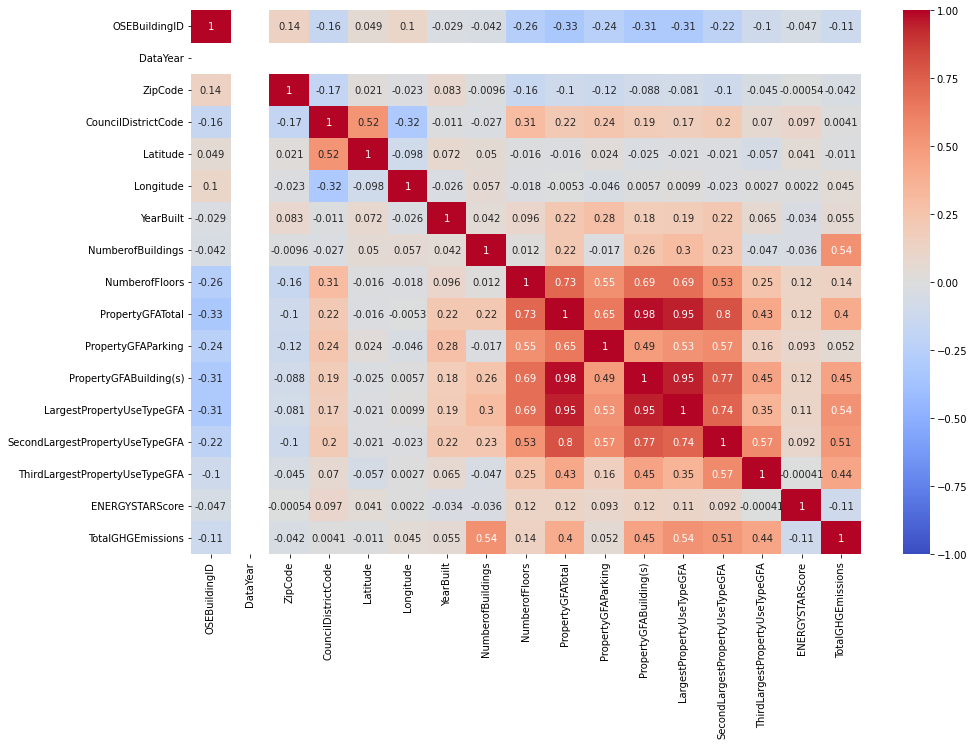

In [ ]:
plt.figure(figsize=(15,10))
fig = sns.heatmap(data_EmissionsCO2.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')
plt.show()

In [ ]:
data_EmissionsCO2['DataYear'].unique()

array([2016])

DataYear = 2016 pour toute les variables .On supprimera cette colonne car elle n'apporte rien à notre étude

On supprimera les colonnes Address, PropertyName, Address, City, State, ZipCode, TaxParcelIdentificationNumber car on a déja la longitude et la latitude qui donne les coordonnés des bâtiments


In [ ]:
data_EmissionsCO2.min()

OSEBuildingID                                                                  1
DataYear                                                                    2016
BuildingType                                                              Campus
PrimaryPropertyType                                          Distribution Center
PropertyName                                                    #4706 Bitterlake
Address                                                          10 Harrison St.
City                                                                     Seattle
State                                                                         WA
ZipCode                                                                  98020.0
TaxParcelIdentificationNumber                                         0001800113
CouncilDistrictCode                                                            1
Neighborhood                                                             BALLARD
Latitude                    

In [ ]:
data_EmissionsCO2.max()

OSEBuildingID                                                50222
DataYear                                                      2016
BuildingType                                     SPS-District K-12
PrimaryPropertyType                               Worship Facility
PropertyName                                          property #50
Address                            Facilities Management MS: B-120
City                                                       Seattle
State                                                           WA
ZipCode                                                    98199.0
TaxParcelIdentificationNumber                           9826701245
CouncilDistrictCode                                              7
Neighborhood                                             SOUTHWEST
Latitude                                                  47.73387
Longitude                                               -122.25864
YearBuilt                                                     

In [ ]:
data_EmissionsCO2.drop(['DataYear', 'PropertyName', 'Address', 'ZipCode', 'ZipCode', 'City', 'State', 'TaxParcelIdentificationNumber', 'ListOfAllPropertyUseTypes'], axis = 1, inplace = True)
#data_EmissionsCO2['RatioPropertyTotalGFA_On_max'] = data_EmissionsCO2['PropertyGFATotal'] / data_EmissionsCO2['PropertyGFATotal'].max()
data_EmissionsCO2.shape

(1094, 21)

On supprime les variables non coréllé à la variable cible et on crée de nouvelle variable à partir des varible structurelles corrélé à la variable cible.
On supprime les variables structurelles corrélés entre elle pour n'en gardé qu'une seul 

In [ ]:
#data_EmissionsCO2['Localisation'] = 'Lat:'+ data_EmissionsCO2['Latitude'].astype(str) + ','+'Long:' +data_EmissionsCO2['Longitude'].astype(str)
#data_EmissionsCO2['BuildingSize'] =  data_EmissionsCO2['PropertyGFABuilding(s)'] * data_EmissionsCO2['NumberofFloors']
#, 'Latitude', 'Longitude'
data_EmissionsCO2.drop(['OSEBuildingID', 'Latitude', 'Longitude'], axis = 1, inplace = True)
data_EmissionsCO2.drop(['PropertyGFAParking', 'YearBuilt', 'CouncilDistrictCode', 'NumberofFloors'], axis = 1, inplace = True) #elle n'est pas corrélé à la cible

#ON transforme les variable en Log decimal
#data_EmissionsCO2['Log2_LargestPropertyUseTypeGFA'] = np.log(data_EmissionsCO2['LargestPropertyUseTypeGFA'])
#data_EmissionsCO2['Log2_PropertyGFATotal'] = np.log(data_EmissionsCO2['PropertyGFATotal'])
#data_EmissionsCO2['Log2_PropertyGFABuilding(s)'] = np.log(data_EmissionsCO2['PropertyGFABuilding(s)'])

data_EmissionsCO2.drop(['PropertyGFATotal', 'PropertyGFABuilding(s)', 'ThirdLargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA'], axis = 1, inplace = True)

Engenering sur les variables catégorielles

In [ ]:
data_EmissionsCO2['PrimaryPropertyType'].unique()

array(['Hotel', 'Other', 'K-12 School', 'Mixed Use Property',
       'Small- and Mid-Sized Office', 'Large Office',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital', 'Residence Hall', 'Warehouse', 'Worship Facility',
       'Supermarket / Grocery Store', 'Distribution Center',
       'Refrigerated Warehouse', 'Low-Rise Multifamily', 'Office'],
      dtype=object)

In [ ]:
data_EmissionsCO2['LargestPropertyUseType'].unique()

array(['Hotel', 'Courthouse', 'K-12 School', 'Office',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital (General Medical & Surgical)',
       'Residence Hall/Dormitory', 'Financial Office',
       'Non-Refrigerated Warehouse', 'Worship Facility', 'Data Center',
       'Parking', 'Supermarket/Grocery Store', 'Distribution Center',
       'Wholesale Club/Supercenter', 'Refrigerated Warehouse', 'Other',
       'Multifamily Housing', 'Bank Branch'], dtype=object)

In [ ]:
data_EmissionsCO2['SecondLargestPropertyUseType'].unique()

array(['None', 'Parking', 'Laboratory', 'Non-Refrigerated Warehouse',
       'Other - Education', 'Retail Store',
       'Other - Entertainment/Public Assembly', 'Restaurant',
       'Swimming Pool', 'Self-Storage Facility', 'Office',
       'Other - Services', 'Other - Recreation',
       'Convenience Store without Gas Station', 'Other',
       'Performing Arts', 'College/University',
       'Supermarket/Grocery Store', 'Data Center', 'Adult Education',
       'Distribution Center', 'Multifamily Housing', 'Bar/Nightclub',
       'Financial Office', 'Manufacturing/Industrial Plant',
       'Bank Branch', 'K-12 School', 'Hotel', 'Worship Facility',
       'Medical Office', 'Pre-school/Daycare', 'Other - Restaurant/Bar'],
      dtype=object)

In [ ]:
data_EmissionsCO2['ThirdLargestPropertyUseType'].unique()

array(['None', 'Restaurant', 'Swimming Pool',
       'Non-Refrigerated Warehouse', 'Data Center', 'Retail Store',
       'Other', 'Other - Services', 'Medical Office', 'Food Service',
       'Parking', 'Fitness Center/Health Club/Gym', 'Social/Meeting Hall',
       'Pre-school/Daycare', 'Convenience Store without Gas Station',
       'Financial Office', 'Other - Restaurant/Bar', 'Other - Education',
       'Distribution Center', 'Office', 'Laboratory', 'Bank Branch',
       'Other - Entertainment/Public Assembly', 'Multifamily Housing',
       'Hotel', 'Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'Other - Recreation', 'Other - Technology/Science',
       'Refrigerated Warehouse', 'Bar/Nightclub',
       'Other/Specialty Hospital', 'Worship Facility'], dtype=object)

On crée de nouvelle modalités qui rassemble ceux existante


> Entertainment = 'Other - Entertainment/Public Assembly', 'Swimming Pool', 'Other - Recreation', 'Other', 'Performing Arts', 'Bar/Nightclub', 'Social/Meeting Hall'


> Restauration - Hotel = 'Hotel', 'Residence Hall/Dormitory','Multifamily Housing', 'Restaurant', 'Other - Restaurant/Bar', 'Food Service'


> Office = 'Courthouse', 'Office', 'Financial Office', 'Worship Facility', 'Bank Branch', 'Personal Services (Health/Beauty, Dry Cleaning, etc)'


> Store - Market = 'Supermarket/Grocery Store', 'Retail Store', 'Wholesale Club/Supercenter', 'Convenience Store without Gas Station'

> Center - Warehouse =  'Refrigerated Warehouse', 'Distribution Center', 'Non-Refrigerated Warehouse','Self-Storage Facility', 'Other - Services', 'Manufacturing/Industrial Plant'

> Science = 'Laboratory', 'Data Center', 'Other - Technology/Science'


> Education = 'K-12 School', 'Other - Education', 'College/University', 'Adult Education', 'Pre-school/Daycare'

> Medical & Health = 'Senior Care Community', 'Medical Office', 'Hospital (General Medical & Surgical)', 'Fitness Center/Health Club/Gym', 'Other/Specialty Hospital'

In [ ]:
# "LargestPropertyUseType" et "PrimaryPropertyType" sont assez redondante donc on supprimeras "PrimaryPropertyType" car elle est repris dans la variable LargestPropertyUseType
data_EmissionsCO2.drop(['PrimaryPropertyType'], axis = 1, inplace = True)

#Entertainment = 'Other - Entertainment/Public Assembly', 'Swimming Pool', 'Other - Recreation', 'Other', 'Performing Arts', 'Bar/Nightclub', 'Social/Meeting Hall'
mask1 = data_EmissionsCO2['LargestPropertyUseType'].isin(['Other - Entertainment/Public Assembly', 'Swimming Pool', 'Other - Recreation', 'Other', 'Performing Arts', 'Bar/Nightclub', 'Social/Meeting Hall'])
mask2 = data_EmissionsCO2['SecondLargestPropertyUseType'].isin(['Other - Entertainment/Public Assembly', 'Swimming Pool', 'Other - Recreation', 'Other', 'Performing Arts', 'Bar/Nightclub', 'Social/Meeting Hall'])
mask3 = data_EmissionsCO2['ThirdLargestPropertyUseType'].isin(['Other - Entertainment/Public Assembly', 'Swimming Pool', 'Other - Recreation', 'Other', 'Performing Arts', 'Bar/Nightclub', 'Social/Meeting Hall'])

data_EmissionsCO2.loc[mask1, 'LargestPropertyUseType'] = 'Entertainment'
data_EmissionsCO2.loc[mask2, 'SecondLargestPropertyUseType'] = 'Entertainment'
data_EmissionsCO2.loc[mask3, 'ThirdLargestPropertyUseType'] = 'Entertainment'

#Restauration - Hotel = 'Hotel', 'Residence Hall/Dormitory','Multifamily Housing', 'Restaurant', 'Other - Restaurant/Bar', 'Food Service'
mask1 = data_EmissionsCO2['LargestPropertyUseType'].isin(['Hotel', 'Residence Hall/Dormitory','Multifamily Housing', 'Restaurant', 'Other - Restaurant/Bar', 'Food Service'])
mask2 = data_EmissionsCO2['SecondLargestPropertyUseType'].isin(['Hotel', 'Residence Hall/Dormitory','Multifamily Housing', 'Restaurant', 'Other - Restaurant/Bar', 'Food Service'])
mask3 = data_EmissionsCO2['ThirdLargestPropertyUseType'].isin(['Hotel', 'Residence Hall/Dormitory','Multifamily Housing', 'Restaurant', 'Other - Restaurant/Bar', 'Food Service'])

data_EmissionsCO2.loc[mask1, 'LargestPropertyUseType'] = 'Restauration - Hotel'
data_EmissionsCO2.loc[mask2, 'SecondLargestPropertyUseType'] = 'Restauration - Hotel'
data_EmissionsCO2.loc[mask3, 'ThirdLargestPropertyUseType'] = 'Restauration - Hotel'

#Office = 'Courthouse', 'Office', 'Financial Office', 'Worship Facility', 'Bank Branch', 'Personal Services (Health/Beauty, Dry Cleaning, etc)'
mask1 = data_EmissionsCO2['LargestPropertyUseType'].isin(['Courthouse', 'Office', 'Financial Office', 'Worship Facility', 'Bank Branch', 'Personal Services (Health/Beauty, Dry Cleaning, etc)'])
mask2 = data_EmissionsCO2['SecondLargestPropertyUseType'].isin(['Courthouse', 'Office', 'Financial Office', 'Worship Facility', 'Bank Branch', 'Personal Services (Health/Beauty, Dry Cleaning, etc)'])
mask3 = data_EmissionsCO2['ThirdLargestPropertyUseType'].isin(['Courthouse', 'Office', 'Financial Office', 'Worship Facility', 'Bank Branch', 'Personal Services (Health/Beauty, Dry Cleaning, etc)'])

data_EmissionsCO2.loc[mask1, 'LargestPropertyUseType'] = 'Office'
data_EmissionsCO2.loc[mask2, 'SecondLargestPropertyUseType'] = 'Office'
data_EmissionsCO2.loc[mask3, 'ThirdLargestPropertyUseType'] = 'Office'

#Store - Market = 'Supermarket/Grocery Store', 'Retail Store', 'Wholesale Club/Supercenter', 'Convenience Store without Gas Station'
mask1 = data_EmissionsCO2['LargestPropertyUseType'].isin(['Supermarket/Grocery Store', 'Retail Store', 'Wholesale Club/Supercenter', 'Convenience Store without Gas Station'])
mask2 = data_EmissionsCO2['SecondLargestPropertyUseType'].isin(['Supermarket/Grocery Store', 'Retail Store', 'Wholesale Club/Supercenter', 'Convenience Store without Gas Station'])
mask3 = data_EmissionsCO2['ThirdLargestPropertyUseType'].isin(['Supermarket/Grocery Store', 'Retail Store', 'Wholesale Club/Supercenter', 'Convenience Store without Gas Station'])

data_EmissionsCO2.loc[mask1, 'LargestPropertyUseType'] = 'Store - Market'
data_EmissionsCO2.loc[mask2, 'SecondLargestPropertyUseType'] = 'Store - Market'
data_EmissionsCO2.loc[mask3, 'ThirdLargestPropertyUseType'] = 'Store - Market'

#Center - Warehouse =  'Refrigerated Warehouse', 'Distribution Center', 'Non-Refrigerated Warehouse','Self-Storage Facility', 'Other - Services', 'Manufacturing/Industrial Plant'
mask1 = data_EmissionsCO2['LargestPropertyUseType'].isin(['Refrigerated Warehouse', 'Distribution Center', 'Non-Refrigerated Warehouse','Self-Storage Facility', 'Other - Services', 'Manufacturing/Industrial Plant'])
mask2 = data_EmissionsCO2['SecondLargestPropertyUseType'].isin(['Refrigerated Warehouse', 'Distribution Center', 'Non-Refrigerated Warehouse','Self-Storage Facility', 'Other - Services', 'Manufacturing/Industrial Plant'])
mask3 = data_EmissionsCO2['ThirdLargestPropertyUseType'].isin(['Refrigerated Warehouse', 'Distribution Center', 'Non-Refrigerated Warehouse','Self-Storage Facility', 'Other - Services', 'Manufacturing/Industrial Plant'])

data_EmissionsCO2.loc[mask1, 'LargestPropertyUseType'] = 'Center - Warehouse'
data_EmissionsCO2.loc[mask2, 'SecondLargestPropertyUseType'] = 'Center - Warehouse'
data_EmissionsCO2.loc[mask3, 'ThirdLargestPropertyUseType'] = 'Center - Warehouse'

#Science = 'Laboratory', 'Data Center', 'Other - Technology/Science'
mask1 = data_EmissionsCO2['LargestPropertyUseType'].isin(['Laboratory', 'Data Center', 'Other - Technology/Science'])
mask2 = data_EmissionsCO2['SecondLargestPropertyUseType'].isin(['Laboratory', 'Data Center', 'Other - Technology/Science'])
mask3 = data_EmissionsCO2['ThirdLargestPropertyUseType'].isin(['Laboratory', 'Data Center', 'Other - Technology/Science'])

data_EmissionsCO2.loc[mask1, 'LargestPropertyUseType'] = 'Science'
data_EmissionsCO2.loc[mask2, 'SecondLargestPropertyUseType'] = 'Science'
data_EmissionsCO2.loc[mask3, 'ThirdLargestPropertyUseType'] = 'Science'

#Education = 'K-12 School', 'Other - Education', 'College/University', 'Adult Education', 'Pre-school/Daycare'
mask1 = data_EmissionsCO2['LargestPropertyUseType'].isin(['K-12 School', 'Other - Education', 'College/University', 'Adult Education', 'Pre-school/Daycare'])
mask2 = data_EmissionsCO2['SecondLargestPropertyUseType'].isin(['K-12 School', 'Other - Education', 'College/University', 'Adult Education', 'Pre-school/Daycare'])
mask3 = data_EmissionsCO2['ThirdLargestPropertyUseType'].isin(['K-12 School', 'Other - Education', 'College/University', 'Adult Education', 'Pre-school/Daycare'])

data_EmissionsCO2.loc[mask1, 'LargestPropertyUseType'] = 'Education'
data_EmissionsCO2.loc[mask2, 'SecondLargestPropertyUseType'] = 'Education'
data_EmissionsCO2.loc[mask3, 'ThirdLargestPropertyUseType'] = 'Education'

#Medical & Health = 'Senior Care Community', 'Medical Office', 'Hospital (General Medical & Surgical)', 'Fitness Center/Health Club/Gym', 'Other/Specialty Hospital'
mask1 = data_EmissionsCO2['LargestPropertyUseType'].isin(['Senior Care Community', 'Medical Office', 'Hospital (General Medical & Surgical)', 'Fitness Center/Health Club/Gym', 'Other/Specialty Hospital'])
mask2 = data_EmissionsCO2['SecondLargestPropertyUseType'].isin(['Senior Care Community', 'Medical Office', 'Hospital (General Medical & Surgical)', 'Fitness Center/Health Club/Gym', 'Other/Specialty Hospital'])
mask3 = data_EmissionsCO2['ThirdLargestPropertyUseType'].isin(['Senior Care Community', 'Medical Office', 'Hospital (General Medical & Surgical)', 'Fitness Center/Health Club/Gym', 'Other/Specialty Hospital'])

data_EmissionsCO2.loc[mask1, 'LargestPropertyUseType'] = 'Medical & Health'
data_EmissionsCO2.loc[mask2, 'SecondLargestPropertyUseType'] = 'Medical & Health'
data_EmissionsCO2.loc[mask3, 'ThirdLargestPropertyUseType'] = 'Medical & Health'

In [ ]:
#On combine les types d'utilisation afin d'en faire une seul
#data_EmissionsCO2['ThreePrincipalPropertyUseType'] = 

In [ ]:
data_EmissionsCO2['SecondLargestPropertyUseType'].unique()

array(['None', 'Parking', 'Science', 'Center - Warehouse', 'Education',
       'Store - Market', 'Entertainment', 'Restauration - Hotel',
       'Office', 'Medical & Health'], dtype=object)

In [ ]:
data_EmissionsCO2.drop(['ThirdLargestPropertyUseType'], axis=1, inplace = True)

In [ ]:
data_EmissionsCO2.dtypes

BuildingType                     object
Neighborhood                     object
NumberofBuildings               float64
LargestPropertyUseType           object
LargestPropertyUseTypeGFA       float64
SecondLargestPropertyUseType     object
ENERGYSTARScore                 float64
TotalGHGEmissions               float64
dtype: object

In [ ]:
data_EmissionsCO2.shape

(1094, 8)

ON visualise la carte des corrélations de nos variable numérique. ON constate que les variale structurelles sont corrélées à la variable cible et ne sont pas corrélé entre elle. Ce qui fait que nos données sont prêts pour la prédiction

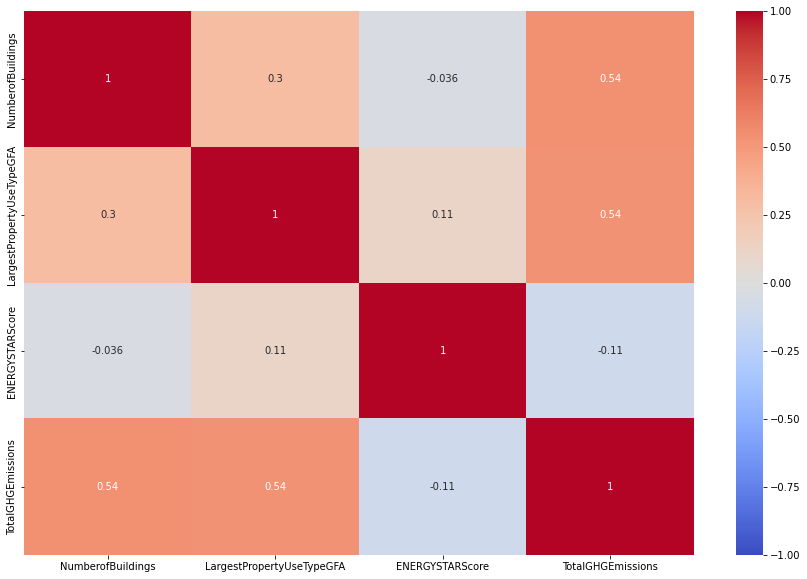

In [ ]:
plt.figure(figsize=(15,10))
fig = sns.heatmap(data_EmissionsCO2.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')
plt.show()

# Etape 2: Sampling et pré-processing

In [ ]:
data_EmissionsCO2.shape

(1094, 8)

##Création des vecteurs 'data' et de la 'target'

On crée pour notre prédiction une target et deux dataframe data. Une data sans énergystarscore et une avec l'energystar score afin de mesurer l'impact de ce dernier sur la prédiction de l'emissions de CO2:

- data

-data_with_ESS : dataframe avec Energystarscore

In [ ]:
data = resample(data_EmissionsCO2, n_samples = 400, random_state = 10)
data = data.drop_duplicates()
target = data['TotalGHGEmissions']
data_with_ESS = data.drop(['TotalGHGEmissions'], axis = 1) #Avec energystarscore
data = data.drop(['TotalGHGEmissions','ENERGYSTARScore'], axis = 1) #Sans energystarscore

In [ ]:
print('Data sans energystarscore taille : ', data.shape)
print('Data avec energystarscore taille : ', data_with_ESS.shape)

Data sans energystarscore taille :  (343, 6)
Data avec energystarscore taille :  (343, 7)


In [ ]:
target.shape

(343,)

In [ ]:
data.duplicated().sum()

0

##Sampling ou séparation de nos données d'entrainement et de test

On réalise la séparation de nos données d'entrainement et de test

68 % sera utilisé pour entrainer nos modèles et le reste pour réaliser les test

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(data, target, train_size=0.7, random_state=10) # Sans energystarscore
xtrain_with_ESS, xtest_with_ESS, ytrain_with_ESS, ytest_with_ESS = train_test_split(data_with_ESS, target, train_size=0.7, random_state=10) # Avec Energystarscore

In [ ]:
print('xtrain taille: ', xtrain.shape)
print('ytrain taille: ', ytrain.shape)

print('xtest taille: ', xtest.shape)
print('ytest taille: ', ytest.shape)

print('xtrain avec Energystarscore taille: ', xtrain_with_ESS.shape)
print('ytrain avec Energystarscore taille: ', ytrain_with_ESS.shape)

print('xtest avec Energystarscore taille: ', xtest_with_ESS.shape)
print('ytest avec Energystarscore taille: ', ytest_with_ESS.shape)

xtrain taille:  (240, 6)
ytrain taille:  (240,)
xtest taille:  (103, 6)
ytest taille:  (103,)
xtrain avec Energystarscore taille:  (240, 7)
ytrain avec Energystarscore taille:  (240,)
xtest avec Energystarscore taille:  (103, 7)
ytest avec Energystarscore taille:  (103,)


In [ ]:
xtrain.dtypes

BuildingType                     object
Neighborhood                     object
NumberofBuildings               float64
LargestPropertyUseType           object
LargestPropertyUseTypeGFA       float64
SecondLargestPropertyUseType     object
dtype: object

##Normalisation & One-hot Encoding

On fera un one-hot encoding pour normaliser les données catégorielle et un scaler pour standardiser les données catégorielle

### Sans EnergyStarScore

In [ ]:
categorical_cols = xtrain.columns[xtrain.dtypes==object]
numerical_cols = xtrain.select_dtypes(exclude='object').columns


categorical_test_cols = xtest.columns[xtest.dtypes==object]
numerical_test_cols = xtest.select_dtypes(exclude='object').columns

In [ ]:
# # Create pipeline for numeric features
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
#     ('scaler', StandardScaler())
# ])

In [ ]:
# #Create pipeline for categorical features
# categorical_transformer = Pipeline(
#    steps=[
#    ('encoder', OneHotEncoder(handle_unknown='ignore')) # first column will be dropped to avoid creating correlations between features
#    ])

In [ ]:
# # Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
# preprocessor = ColumnTransformer(
#    transformers=[
#        ('num', numeric_transformer, numerical_cols),
#        ('cat', categorical_transformer, categorical_cols)
#    ])

In [ ]:
xtrain

,BuildingType,Neighborhood,NumberofBuildings,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType
207,NonResidential,DOWNTOWN,1.0,Office,748011.0,Parking
214,NonResidential,EAST,1.0,Medical & Health,162000.0,Parking
1024,NonResidential,EAST,1.0,Office,52225.0,None
1006,NonResidential,GREATER DUWAMISH,1.0,Center - Warehouse,32546.0,None
313,NonResidential,GREATER DUWAMISH,1.0,Center - Warehouse,76486.0,None
...,...,...,...,...,...,...
330,NonResidential,GREATER DUWAMISH,1.0,Center - Warehouse,85343.0,Office
478,SPS-District K-12,CENTRAL,1.0,Education,48887.0,None
77,NonResidential,NORTH,1.0,Store - Market,505103.0,Restauration - Hotel
258,NonResidential,NORTHWEST,1.0,Store - Market,107931.0,None


In [ ]:
xtest[xtest["BuildingType"].isin(["Campus"])]

,BuildingType,Neighborhood,NumberofBuildings,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType
1021,Campus,CENTRAL,1.0,Education,30562.0,None


In [ ]:
# # Preprocessings on train set
# print("Performing preprocessings on train set...")
# print(xtrain.head())
# xtrain = preprocessor.fit_transform(xtrain)
# print('...Done.')
# print(xtrain[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
# print()

# #Preprocessings on test set
# print("Performing preprocessings on test set...")
# print(xtest.head()) 
# xtest = preprocessor.transform(xtest) # Don't fit again !! The test set is used for validating decisions
# #we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# #Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
# print('...Done.')
# print(xtest[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
# print()

In [ ]:
ohe = OneHotEncoder(handle_unknown = 'ignore') #ignore tells the encoder to ignore new categories by encoding them with 0's

ohe.fit(xtrain[categorical_cols])

X_train_ohe = ohe.transform(xtrain[categorical_cols]).todense()

X_test_ohe = ohe.transform(xtest[categorical_test_cols]).todense()

In [ ]:
scaler = StandardScaler()

scaler.fit(xtrain[numerical_cols])

X_train_scaler = scaler.transform(xtrain[numerical_cols])

X_test_scaler = scaler.transform(xtest[numerical_test_cols])

In [ ]:
# train
xtrain = pd.DataFrame(X_train_scaler, columns = numerical_cols).join(pd.DataFrame(X_train_ohe, columns = ohe.get_feature_names()))
xtrain

,NumberofBuildings,LargestPropertyUseTypeGFA,x0_NonResidential,x0_Nonresidential COS,x0_SPS-District K-12,x1_BALLARD,x1_Ballard,x1_CENTRAL,x1_DELRIDGE,x1_DOWNTOWN,...,x2_Store - Market,x3_Center - Warehouse,x3_Education,x3_Entertainment,x3_None,x3_Office,x3_Parking,x3_Restauration - Hotel,x3_Science,x3_Store - Market
0,-0.063398,3.994021,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.063398,0.342567,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.063398,-0.341444,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.063398,-0.464065,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.063398,-0.190273,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,-0.063398,-0.135085,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
236,-0.063398,-0.362244,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
237,-0.063398,2.480453,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
238,-0.063398,0.005662,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# test
xtest = pd.DataFrame(X_test_scaler, columns = numerical_cols).join(pd.DataFrame(X_test_ohe, columns = ohe.get_feature_names()))
xtest

,NumberofBuildings,LargestPropertyUseTypeGFA,x0_NonResidential,x0_Nonresidential COS,x0_SPS-District K-12,x1_BALLARD,x1_Ballard,x1_CENTRAL,x1_DELRIDGE,x1_DOWNTOWN,...,x2_Store - Market,x3_Center - Warehouse,x3_Education,x3_Entertainment,x3_None,x3_Office,x3_Parking,x3_Restauration - Hotel,x3_Science,x3_Store - Market
0,-0.063398,-0.362792,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.063398,-0.296089,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.063398,-0.369017,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.063398,-0.472701,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.063398,-0.495046,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,-0.063398,-0.340821,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
99,-0.063398,-0.535684,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,-0.063398,-0.358592,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
101,-0.063398,-0.548470,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Avec EnergyStarScore

In [ ]:
categorical_cols_with_ESS = xtrain_with_ESS.columns[xtrain_with_ESS.dtypes==object]
numerical_cols_with_ESS = xtrain_with_ESS.select_dtypes(exclude='object').columns


categorical_test_cols_with_ESS = xtest_with_ESS.columns[xtest_with_ESS.dtypes==object]
numerical_test_cols_with_ESS = xtest_with_ESS.select_dtypes(exclude='object').columns

In [ ]:
# # Create pipeline for numeric features
# numeric_transformer_with_ESS = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
#    ('scaler', StandardScaler())
# ])

In [ ]:
# # Create pipeline for categorical features
# categorical_transformer_with_ESS = Pipeline(
#    steps=[
#    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
#   ])

In [ ]:
# # Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
# preprocessor_with_ESS = ColumnTransformer(
#    transformers=[
#        ('num', numeric_transformer_with_ESS, numerical_cols_with_ESS),
#        ('cat', categorical_transformer_with_ESS, categorical_cols_with_ESS)
#    ])

In [ ]:
# # Preprocessings on train set
# print("Performing preprocessings on train set...")
# print(xtrain_with_ESS.head())
# xtrain_with_ESS = preprocessor.fit_transform(xtrain_with_ESS)
# print('...Done.')
# print(xtrain_with_ESS[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
# print()

# # Preprocessings on test set
# print("Performing preprocessings on test set...")
# print(xtest_with_ESS.head()) 
# xtest_with_ESS = preprocessor.transform(xtest_with_ESS) # Don't fit again !! The test set is used for validating decisions
# # we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# # Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
# print('...Done.')
# print(xtest_with_ESS[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
# print()

In [ ]:
ohe_with_ESS = OneHotEncoder(handle_unknown = 'ignore') #ignore tells the with_ESScoder to ignore new categories by with_ESScoding them with 0's

ohe_with_ESS.fit(xtrain_with_ESS[categorical_cols_with_ESS])

X_train_ohe_with_ESS = ohe_with_ESS.transform(xtrain_with_ESS[categorical_cols_with_ESS]).todense()

X_test_ohe_with_ESS = ohe_with_ESS.transform(xtest_with_ESS[categorical_test_cols_with_ESS]).todense()

In [ ]:
scaler_with_ESS = StandardScaler()

scaler_with_ESS.fit(xtrain_with_ESS[numerical_cols_with_ESS])


X_train_scaler_with_ESS = scaler_with_ESS.transform(xtrain_with_ESS[numerical_cols_with_ESS])


X_test_scaler_with_ESS = scaler_with_ESS.transform(xtest_with_ESS[numerical_test_cols_with_ESS])

In [ ]:
# train
xtrain_with_ESS = pd.DataFrame(X_train_scaler_with_ESS, columns = numerical_cols_with_ESS).join(pd.DataFrame(X_train_ohe_with_ESS, columns = ohe_with_ESS.get_feature_names()))
xtrain_with_ESS

,NumberofBuildings,LargestPropertyUseTypeGFA,ENERGYSTARScore,x0_NonResidential,x0_Nonresidential COS,x0_SPS-District K-12,x1_BALLARD,x1_Ballard,x1_CENTRAL,x1_DELRIDGE,...,x2_Store - Market,x3_Center - Warehouse,x3_Education,x3_Entertainment,x3_None,x3_Office,x3_Parking,x3_Restauration - Hotel,x3_Science,x3_Store - Market
0,-0.063398,3.994021,1.031413,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.063398,0.342567,-0.051374,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.063398,-0.341444,-0.994447,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.063398,-0.464065,1.171128,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.063398,-0.190273,0.123269,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,-0.063398,-0.135085,-0.365732,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
236,-0.063398,-0.362244,0.891699,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
237,-0.063398,2.480453,1.101271,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
238,-0.063398,0.005662,0.193126,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# test
xtest_with_ESS = pd.DataFrame(X_test_scaler_with_ESS, columns = numerical_cols_with_ESS).join(pd.DataFrame(X_test_ohe_with_ESS, columns = ohe_with_ESS.get_feature_names()))
xtest_with_ESS

,NumberofBuildings,LargestPropertyUseTypeGFA,ENERGYSTARScore,x0_NonResidential,x0_Nonresidential COS,x0_SPS-District K-12,x1_BALLARD,x1_Ballard,x1_CENTRAL,x1_DELRIDGE,...,x2_Store - Market,x3_Center - Warehouse,x3_Education,x3_Entertainment,x3_None,x3_Office,x3_Parking,x3_Restauration - Hotel,x3_Science,x3_Store - Market
0,-0.063398,-0.362792,0.577341,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.063398,-0.296089,0.472555,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.063398,-0.369017,0.158198,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.063398,-0.472701,-2.251878,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.063398,-0.495046,0.228055,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,-0.063398,-0.340821,0.018483,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
99,-0.063398,-0.535684,-1.623163,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,-0.063398,-0.358592,-1.273876,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
101,-0.063398,-0.548470,0.996485,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Etape 3: Modélisation

In [ ]:
print('xtest taille: ', xtest.shape)
print('ytest taille: ', ytest.shape)

print('xtest_with_ESS taille: ', xtest_with_ESS.shape)
print('ytest_with_ESS taille: ', ytest_with_ESS.shape)

print('xtrain taille: ', xtrain.shape)
print('ytrain taille: ', ytrain.shape)

print('xtrain_with_ESS taille: ', xtrain_with_ESS.shape)
print('ytrain_with_ESS taille: ', ytrain_with_ESS.shape)

xtest taille:  (103, 37)
ytest taille:  (103,)
xtest_with_ESS taille:  (103, 38)
ytest_with_ESS taille:  (103,)
xtrain taille:  (240, 37)
ytrain taille:  (240,)
xtrain_with_ESS taille:  (240, 38)
ytrain_with_ESS taille:  (240,)


Méthode à suivre pour la modélisation avec et sans energystarscore

* Avec la fonction ML on réalise les premiers modèles avec des paramètres par 
défaut des modéles de prédiction et on mesurte leur score. Ceci sera résumer dans un tableau: defaultModel_Performance, defaultModel_Performance_with_ESS
* Ensuite avec la fonction ML_GridSearchCV pour réaliser les modèle paramétrées et en mesurer leur pêrformances dans un tableau: paramModel_Performance, paramModel_Performance_with_ESS

##Sans Energystarscore

###Model

In [ ]:
defaultModel_Performance = pd.DataFrame(columns=['Score_train_R2','Score_train_MAE', 'Score_train_RMSE', 'Score_test_R2', 'Score_test_MAE', 'Score_test_RMSE'],
                                        index=['KNN Regressor', 'Dummy Regressor', 'Lasso', 'Ridge', 'Decision Tree', 'SVR', 'ElasticNet', 
                                               'Random Forest Regressor', 'Gradient Boosting Regressor','Stochastic Gradient Descent Regressor (SGDRegressor)'])

paramModel_Performance = pd.DataFrame(columns=['Score_train_R2','Score_train_MAE', 'Score_train_RMSE', 'Score_test_R2', 'Score_test_MAE', 'Score_test_RMSE'],
                                        index=['KNN Regressor', 'Dummy Regressor', 'Lasso', 'Ridge', 'Decision Tree', 'SVR', 'ElasticNet',
                                               'Random Forest Regressor', 'Gradient Boosting Regressor', 'Stochastic Gradient Descent Regressor (SGDRegressor)'])

In [ ]:
#Modélisation avec les paramètres par défault

defaultModel_Performance.loc['KNN Regressor'] = ML(xtrain, ytrain, xtest, ytest, KNeighborsRegressor())  #KNN Regressor
defaultModel_Performance.loc['Dummy Regressor'] = ML(xtrain, ytrain, xtest, ytest, DummyRegressor())  #Dummy Regressor
defaultModel_Performance.loc['Lasso'] = ML(xtrain, ytrain, xtest, ytest, Lasso())  #Lasso
defaultModel_Performance.loc['Ridge'] = ML(xtrain, ytrain, xtest, ytest, Ridge())  #Ridge
defaultModel_Performance.loc['Decision Tree'] = ML(xtrain, ytrain, xtest, ytest, DecisionTreeRegressor())  #Decision Tree
defaultModel_Performance.loc['SVR'] = ML(xtrain, ytrain, xtest, ytest, SVR())   #SVR
defaultModel_Performance.loc['ElasticNet'] = ML(xtrain, ytrain, xtest, ytest, ElasticNet())   #ElasticNet
defaultModel_Performance.loc['Random Forest Regressor'], defaultbest_params_RandomForestRegressor = ML(xtrain, ytrain, xtest, ytest, RandomForestRegressor())  #Random Forest Regressor
defaultModel_Performance.loc['Gradient Boosting Regressor'] = ML(xtrain, ytrain, xtest, ytest, GradientBoostingRegressor())  #Gradient Boosting Regressor
defaultModel_Performance.loc['Stochastic Gradient Descent Regressor (SGDRegressor)'] = ML(xtrain, ytrain, xtest, ytest, SGDRegressor())  #Stochastic Gradient Descent Regressor (SGDRegressor)

In [ ]:
defaultModel_Performance

,Score_train_R2,Score_train_MAE,Score_train_RMSE,Score_test_R2,Score_test_MAE,Score_test_RMSE
KNN Regressor,0.366759,87.3458,290.599153,0.504768,98.079883,291.811154
Dummy Regressor,0.0,139.48425,365.182321,-0.000495,163.791464,414.767666
Lasso,0.582612,117.3219,235.928215,0.755097,92.464019,205.20829
Ridge,0.587768,118.586341,234.466326,0.76104,98.323573,202.7031
Decision Tree,1.0,0.0,0.0,0.54716,117.650291,279.042261
SVR,-0.037382,111.774694,371.945279,-0.03636,125.470067,422.13648
ElasticNet,0.464648,111.384023,267.19575,0.64075,105.454855,248.5399
Random Forest Regressor,0.861879,41.059664,135.718659,0.687188,88.166949,231.920684
Gradient Boosting Regressor,0.973746,42.831187,59.170248,0.642929,99.171021,247.784775
Stochastic Gradient Descent Regressor (SGDRegressor),0.580504,116.444517,236.523254,0.749913,94.659321,207.368486


Le ramdom forest est le modèle le plus performants qu'on a actuellement

**Modélisation avec les paramètres optimisées**

In [ ]:
#KNN Regressor
params_KNN = {#'n_neighbors': [5, 6, 7, 8, 9, 10],
              #'weights' : ['distance'],
              'p': [1,2]
              }
paramModel_Performance.loc['KNN Regressor'], best_params_KNN = ML_GridSearchCV(xtrain, ytrain, xtest, ytest, KNeighborsRegressor(), params_KNN)

#Dummy Regressor
params_Dummy = {'strategy' : ['quantile','mean', 'median'],
                'quantile': [0, 0.5, 0.6, 1],
                #'constant': [0, 1, 0.5, 2,40]
                }
paramModel_Performance.loc['Dummy Regressor'], best_params_Dummy = ML_GridSearchCV(xtrain, ytrain, xtest, ytest, DummyRegressor(), params_Dummy)

#Lasso
params_Lasso = {'alpha' : [0, 0.5, 0.8, 1],
                'max_iter' : [500, 1000, 1500, 2000],
                'tol': [0.1, 0.01, 0.001, 0.0001],
                'random_state' : [10],
                'selection' : [ 'random']
                }
paramModel_Performance.loc['Lasso'], best_params_Lasso , importanceF_Lasso = ML_GridSearchCV(xtrain, ytrain, xtest, ytest, Lasso(), params_Lasso)

#Ridge
params_Ridge = {'alpha' : [0, 0.5, 1],
                'max_iter' : [500, 1000,2000],
                #'tol': [0.1, 0.01, 0.001, 0.0001],
                'random_state' : [10],
                'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
                }
paramModel_Performance.loc['Ridge'], best_params_Ridge, importanceF_Ridge = ML_GridSearchCV(xtrain, ytrain, xtest, ytest, Ridge(), params_Ridge)

#Decision Tree
params_DecisionTree = {'criterion' : ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
                       #'splitter' : ['best', 'random'],
                       #'max_depth' : [2,10,20,40,50],
                       #'max_features' : ['auto', 'sqrt', 'log2'],
                       #'ccp_alpha' : [0.0, 0.1, 0.2, 0.001, 1],
                       'random_state' : [10]
                       }
paramModel_Performance.loc['Decision Tree'], best_params_DecisionTree = ML_GridSearchCV(xtrain, ytrain, xtest, ytest, DecisionTreeRegressor(), params_DecisionTree)

#SVR
params_SVR = {#'gamma' : ['scale'], #kernel coefficient [ici kernel = Radial Basis Function]
              'epsilon' : [0.001, 0.01, 0.1, 1], #erreur tolérée par l'algorithme
              'C' : [0.01, 0.1, 1], #parametre de régularisation
              #'tol': [0.1, 0.01, 0.001],
              }
paramModel_Performance.loc['SVR'], best_params_SVR = ML_GridSearchCV(xtrain, ytrain, xtest, ytest, SVR(), params_SVR)

#ElasticNet
params_ElasticNet = {'tol' : [0.1,0.01,0.001,0.0001],
                      #"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10],  #alpha, coef qui multiplie le terme de pénalité)
                      #"l1_ratio": [0.0, 0.5, 1.0, 0.1], #L1 ratio , =1 équivaut à un Lasso, 0 à un Ridge
                     'random_state' : [10]
                      }  
paramModel_Performance.loc['ElasticNet'], best_params_ElasticNet , importanceF_ElasticNet = ML_GridSearchCV(xtrain, ytrain, xtest, ytest, ElasticNet(), params_ElasticNet)

#Random Forest Regressor
params_RandomForestRegressor ={#'min_samples_leaf' : [1,3,5,10, 20], #nombre de feuilles minimales dans un noeud
                               #'max_features': ['auto', 'sqrt'], #nombre de features observées pour chaque arbre
                               #'n_jobs': [-1],
                               'n_estimators' : [50, 100, 200, 300],
                               'random_state' : [10]
                              }
paramModel_Performance.loc['Random Forest Regressor'], best_params_RandomForestRegressor , importanceF_RandomForestRegressor = ML_GridSearchCV(xtrain, ytrain, xtest, ytest, RandomForestRegressor(), params_RandomForestRegressor)

#Gradient Boosting Regressor
params_GradientBoostingRegressor = {#"loss": ['squared_error', 'absolute_error', 'huber', 'quantile'],
                                    #'learning_rate' : [0, 0.1, 0.2, 0.5,  1],
                                    #'criterion' : ['friedman_mse', 'squared_error', 'mse'],
                                    #'max_depth' : [5,10,30,40,50],
                                    #'max_features' : ['sqrt', 'log2'],
                                    'n_estimators' : [10, 50, 100, 200, 300, 500],
                                    'tol':[0.1, 0.01, 0.001, 0.0001],
                                    "alpha": [0.1, 0.5, 0.9, 1.0],
                                    'random_state' : [10]
                                    }
paramModel_Performance.loc['Gradient Boosting Regressor'], best_params_GradientBoostingRegressor , importanceF_GradientBoostingRegressor= ML_GridSearchCV(xtrain, ytrain, xtest, ytest, GradientBoostingRegressor(), params_GradientBoostingRegressor)

#Stochastic Gradient Descent Regressor (SGDRegressor)
params_SGDRegressor = {
    #'loss': ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty' : ['elasticnet', 'l1', 'l2'],
    'l1_ratio': [0.0, 0.15, 0.3, 0.5, 0.8, 1.0],
    'tol':[0.1, 0.01, 0.001],
    'epsilon' : [0.001, 0.01, 0.1, 1], #erreur tolérée par l'algorithme
    'random_state': [10]
}
paramModel_Performance.loc['Stochastic Gradient Descent Regressor (SGDRegressor)'], best_params_SGDRegressor = ML_GridSearchCV(xtrain, ytrain, xtest, ytest, SGDRegressor(), params_SGDRegressor)

KNeighborsRegressor(p=1)
DummyRegressor(quantile=0.6, strategy='quantile')
Lasso(alpha=1, max_iter=500, random_state=10, selection='random', tol=0.01)
Ridge(alpha=1, max_iter=500, random_state=10, solver='saga')
DecisionTreeRegressor(random_state=10)
SVR(C=1, epsilon=1)
ElasticNet(random_state=10, tol=0.01)
RandomForestRegressor(n_estimators=50, random_state=10)
GradientBoostingRegressor(alpha=0.1, n_estimators=10, random_state=10, tol=0.1)
SGDRegressor(epsilon=0.001, l1_ratio=0.0, penalty='elasticnet', random_state=10,
             tol=0.1)


In [ ]:
paramModel_Performance

,Score_train_R2,Score_train_MAE,Score_train_RMSE,Score_test_R2,Score_test_MAE,Score_test_RMSE
KNN Regressor,0.432699,83.440483,275.053114,0.493915,101.338505,294.991365
Dummy Regressor,-0.023318,117.611567,369.415393,-0.024563,134.880272,419.726808
Lasso,0.5826,117.399191,235.931576,0.755351,92.714474,205.101712
Ridge,0.587291,118.732145,234.60203,0.760646,98.19451,202.869946
Decision Tree,1.0,0.0,0.0,0.41626,119.097961,316.815934
SVR,-0.037399,111.774382,371.948398,-0.036375,125.466921,422.139536
ElasticNet,0.464633,111.38347,267.199433,0.640728,105.457571,248.547201
Random Forest Regressor,0.810058,43.463682,159.154881,0.719977,89.27701,219.429028
Gradient Boosting Regressor,0.806167,89.265639,160.776732,0.650912,106.378763,244.999438
Stochastic Gradient Descent Regressor (SGDRegressor),0.582272,117.170148,236.024336,0.753926,95.024446,205.69817


On constate de les score R^2 sont assez bonne pour nos modèle. Sauf celui du 'Dummy Regressor' et 'SVR' qui n'ont pas de bonnes performances

###**Features imortances.**

On évalueara l'importances de nos différentes features avec la parametrics de base de gridsearch CV

In [ ]:
tab = pd.DataFrame(importanceF_RandomForestRegressor)
tab.index= xtrain.columns
tab.columns = ['importance RF']

tab2 = pd.DataFrame(importanceF_GradientBoostingRegressor)
tab2.index= xtrain.columns
tab2.columns = ['importance GBR']

In [ ]:
tab.sort_values(by = 'importance RF', ascending = False).head(10)

,importance RF
NumberofBuildings,0.452414
LargestPropertyUseTypeGFA,0.342145
x3_None,0.039858
x3_Parking,0.026360
x2_Restauration - Hotel,0.025413
x3_Restauration - Hotel,0.019081
x2_Medical & Health,0.014903
x2_Office,0.011740
x2_Store - Market,0.007550
x1_NORTH,0.006493


In [ ]:
tab2.sort_values(by = 'importance GBR', ascending = False).head(10)

,importance GBR
NumberofBuildings,0.776740
LargestPropertyUseTypeGFA,0.133444
x3_None,0.063400
x3_Parking,0.015825
x2_Office,0.010591
x3_Science,0.000000
x2_Restauration - Hotel,0.000000
x2_Education,0.000000
x2_Entertainment,0.000000
x2_Medical & Health,0.000000


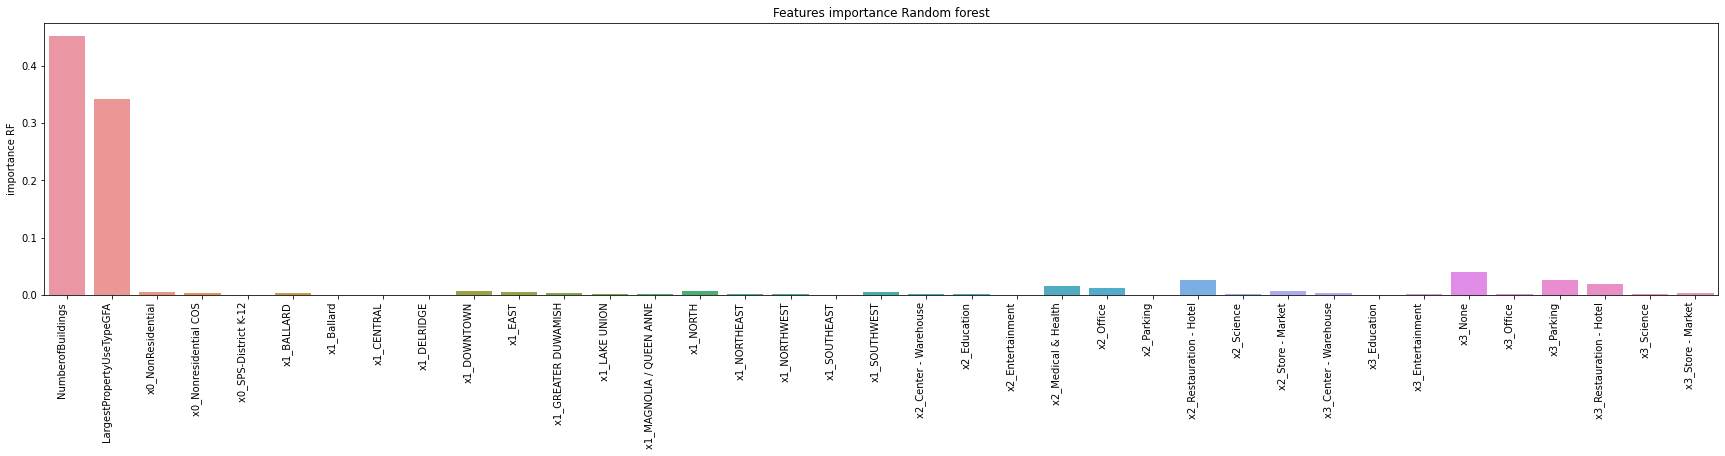

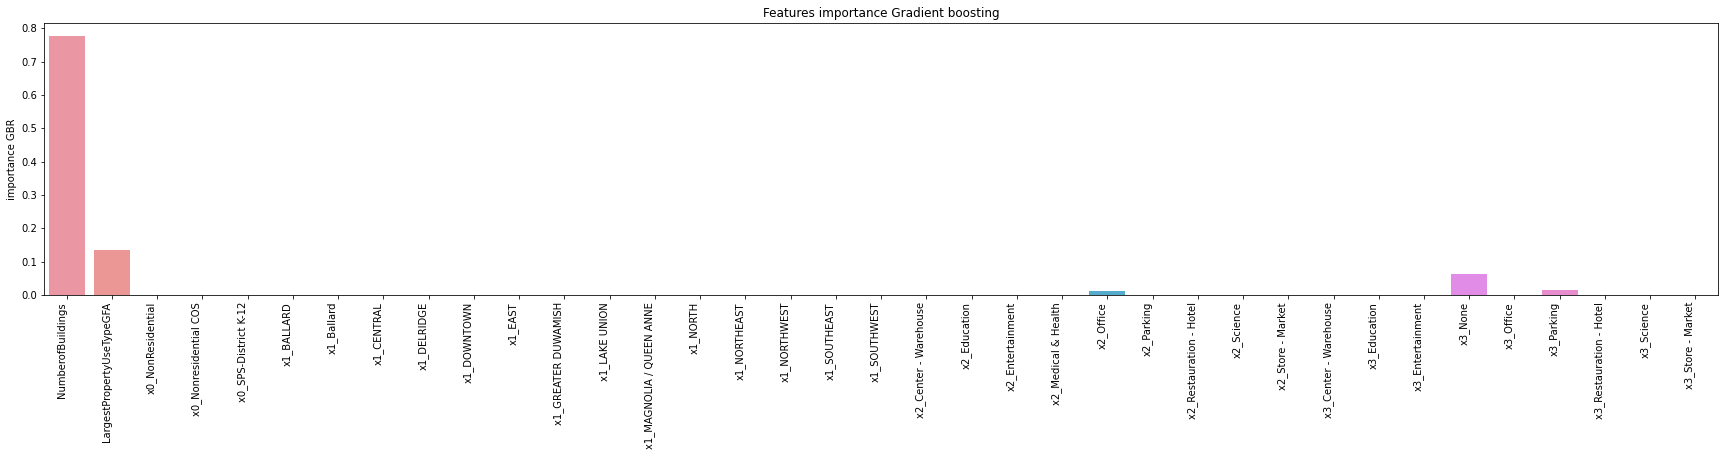

In [ ]:
plt.figure(figsize=(30,5))
sns.barplot(x = tab.index,
            y = tab['importance RF']).set_xticklabels(labels = tab.index,
                      rotation=90,
                    horizontalalignment='right',
                    size=10,
                    )
plt.title('Features importance Random forest')
plt.show()

plt.figure(figsize=(30,5))
sns.barplot(x = tab2.index,
            y = tab2['importance GBR']).set_xticklabels(labels = tab2.index,
                      rotation=90,
                    horizontalalignment='right',
                    size=10,
                    )
plt.title('Features importance Gradient boosting')
plt.show()

**Features importances avec le SHAPE**


In [ ]:
#Modèle d'entrainement

modelRandom = best_params_RandomForestRegressor
modelRandom.fit(xtrain, ytrain)

modelGBR = best_params_GradientBoostingRegressor
#modelGBR.fit(xtrain, ytrain)

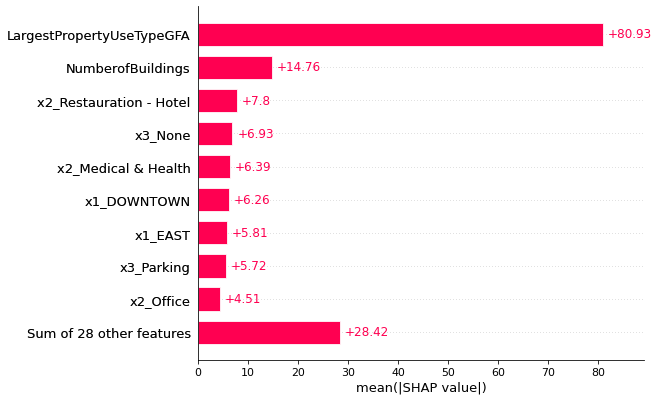

In [ ]:
random_explainer = shap.TreeExplainer(modelRandom, xtrain) #Radom forest
gradient_explainer = shap.TreeExplainer(modelGBR, xtrain) #Gradient boosting
shap_random_value = random_explainer(xtrain, check_additivity=False)
shap_gradient_value = gradient_explainer(xtrain, check_additivity=False)

shap.plots.bar(shap_random_value)

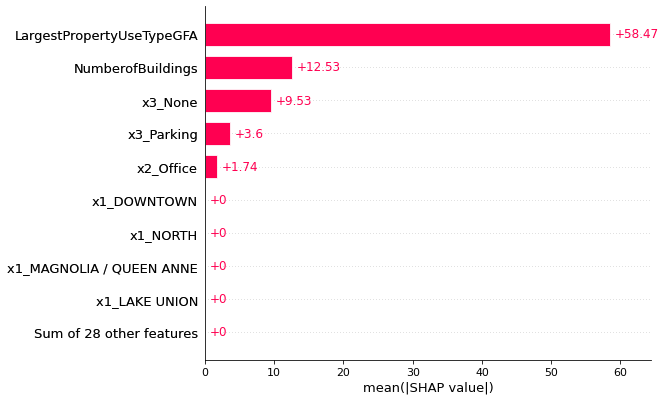

In [ ]:
shap.plots.bar(shap_gradient_value)

Les données ayant le plus d'imporrantnce dans les modèle de prédiction pour le random forest et le gradient boosting sont:

LargestPropertyUseTYpeGFA , NumberofBuildings et Medical & Health

##Avec Energystarscore (Pour mesurer son impact)

###Model

In [ ]:
defaultModel_Performance_with_ESS = pd.DataFrame(columns=['Score_train_R2','Score_train_MAE', 'Score_train_RMSE', 'Score_test_R2', 'Score_test_MAE', 'Score_test_RMSE'],
                                        index=['KNN Regressor', 'Dummy Regressor', 'Lasso', 'Ridge', 'Decision Tree', 'SVR', 'ElasticNet', 
                                               'Random Forest Regressor', 'Gradient Boosting Regressor','Stochastic Gradient Descent Regressor (SGDRegressor)'])

paramModel_Performance_with_ESS = pd.DataFrame(columns=['Score_train_R2','Score_train_MAE', 'Score_train_RMSE', 'Score_test_R2', 'Score_test_MAE', 'Score_test_RMSE'],
                                        index=['KNN Regressor', 'Dummy Regressor', 'Lasso', 'Ridge', 'Decision Tree', 'SVR', 'ElasticNet', 
                                               'Random Forest Regressor', 'Gradient Boosting Regressor','Stochastic Gradient Descent Regressor (SGDRegressor)'])

In [ ]:
#Modélisation avec les paramètres par défault

defaultModel_Performance_with_ESS.loc['KNN Regressor'] = ML(xtrain_with_ESS, ytrain_with_ESS, xtest_with_ESS, ytest_with_ESS, KNeighborsRegressor())  #KNN Regressor
defaultModel_Performance_with_ESS.loc['Dummy Regressor'] = ML(xtrain_with_ESS, ytrain_with_ESS, xtest_with_ESS, ytest_with_ESS, DummyRegressor())  #Dummy Regressor
defaultModel_Performance_with_ESS.loc['Lasso'] = ML(xtrain_with_ESS, ytrain_with_ESS, xtest_with_ESS, ytest_with_ESS, Lasso())  #Lasso
defaultModel_Performance_with_ESS.loc['Ridge'] = ML(xtrain_with_ESS, ytrain_with_ESS, xtest_with_ESS, ytest_with_ESS, Ridge())  #Ridge
defaultModel_Performance_with_ESS.loc['Decision Tree'] = ML(xtrain_with_ESS, ytrain_with_ESS, xtest_with_ESS, ytest_with_ESS, DecisionTreeRegressor())  #Decision Tree
defaultModel_Performance_with_ESS.loc['SVR'] = ML(xtrain_with_ESS, ytrain_with_ESS, xtest_with_ESS, ytest_with_ESS, SVR())   #SVR
defaultModel_Performance_with_ESS.loc['ElasticNet'] = ML(xtrain_with_ESS, ytrain_with_ESS, xtest_with_ESS, ytest_with_ESS, ElasticNet())   #ElasticNet
defaultModel_Performance_with_ESS.loc['Random Forest Regressor'], defaultbest_params_RandomForestRegressor_with_ESS = ML(xtrain_with_ESS, ytrain_with_ESS, xtest_with_ESS, ytest_with_ESS, RandomForestRegressor())  #Random Forest Regressor
defaultModel_Performance_with_ESS.loc['Gradient Boosting Regressor'] = ML(xtrain_with_ESS, ytrain_with_ESS, xtest_with_ESS, ytest_with_ESS, GradientBoostingRegressor())  #Gradient Boosting Regressor
defaultModel_Performance_with_ESS.loc['Stochastic Gradient Descent Regressor (SGDRegressor)'] = ML(xtrain_with_ESS, ytrain_with_ESS, xtest_with_ESS, ytest_with_ESS, SGDRegressor())  #Stochastic Gradient Descent Regressor (SGDRegressor)

In [ ]:
defaultModel_Performance_with_ESS

,Score_train_R2,Score_train_MAE,Score_train_RMSE,Score_test_R2,Score_test_MAE,Score_test_RMSE
KNN Regressor,0.374502,89.642317,288.816881,0.516448,102.552544,288.349364
Dummy Regressor,0.0,139.48425,365.182321,-0.000495,163.791464,414.767666
Lasso,0.595017,118.527353,232.395612,0.767392,89.237687,199.99074
Ridge,0.599919,119.756737,230.984971,0.774619,93.966824,196.859238
Decision Tree,1.0,0.0,0.0,0.416699,119.741068,316.696941
SVR,-0.037561,111.980106,371.977346,-0.036405,125.817098,422.145585
ElasticNet,0.47868,109.077315,263.670789,0.651096,98.713272,244.934593
Random Forest Regressor,0.82923,40.787969,150.909142,0.77617,80.933077,196.180886
Gradient Boosting Regressor,0.982749,35.071546,47.964596,0.693192,92.592956,229.684149
Stochastic Gradient Descent Regressor (SGDRegressor),0.589147,116.456174,234.073894,0.762218,88.709068,202.202857


On utilisera les mêmes essai de paramètres que pour la modélisation sans energystar score et on vera quel paramètres sera choisi par le model gridsearch et leur performances

In [ ]:
#Modélisation avec les paramètres optimisées

#KNN Regressor
paramModel_Performance_with_ESS.loc['KNN Regressor'], best_params_KNN_with_ESS = ML_GridSearchCV(xtrain_with_ESS, ytrain_with_ESS, xtest_with_ESS, ytest_with_ESS, KNeighborsRegressor(), params_KNN)

#Dummy Regressor
paramModel_Performance_with_ESS.loc['Dummy Regressor'], best_params_Dummy_with_ESS = ML_GridSearchCV(xtrain_with_ESS, ytrain_with_ESS, xtest_with_ESS, ytest_with_ESS, DummyRegressor(), params_Dummy)

#Lasso
paramModel_Performance_with_ESS.loc['Lasso'], best_params_Lasso_with_ESS , importanceF_Lasso_with_ESS = ML_GridSearchCV(xtrain_with_ESS, ytrain_with_ESS, xtest_with_ESS, ytest_with_ESS, Lasso(), params_Lasso)

#Ridge
paramModel_Performance_with_ESS.loc['Ridge'], best_params_Ridge_with_ESS, importanceF_Ridge_with_ESS = ML_GridSearchCV(xtrain_with_ESS, ytrain_with_ESS, xtest_with_ESS, ytest_with_ESS, Ridge(), params_Ridge)

#Decision Tree
paramModel_Performance_with_ESS.loc['Decision Tree'], best_params_DecisionTree_with_ESS = ML_GridSearchCV(xtrain_with_ESS, ytrain_with_ESS, xtest_with_ESS, ytest_with_ESS, DecisionTreeRegressor(), params_DecisionTree)

#SVR
paramModel_Performance_with_ESS.loc['SVR'], best_params_SVR_with_ESS = ML_GridSearchCV(xtrain_with_ESS, ytrain_with_ESS, xtest_with_ESS, ytest_with_ESS, SVR(), params_SVR)

#ElasticNet 
paramModel_Performance_with_ESS.loc['ElasticNet'], best_params_ElasticNet_with_ESS , importanceF_ElasticNet_with_ESS = ML_GridSearchCV(xtrain_with_ESS, ytrain_with_ESS, xtest_with_ESS, ytest_with_ESS, ElasticNet(), params_ElasticNet)

#Random Forest Regressor
paramModel_Performance_with_ESS.loc['Random Forest Regressor'], best_params_RandomForestRegressor_with_ESS , importanceF_RandomForestRegressor_with_ESS = ML_GridSearchCV(xtrain_with_ESS, ytrain_with_ESS, xtest_with_ESS, ytest_with_ESS, RandomForestRegressor(), params_RandomForestRegressor)

#Gradient Boosting Regressor
paramModel_Performance_with_ESS.loc['Gradient Boosting Regressor'], best_params_GradientBoostingRegressor_with_ESS , importanceF_GradientBoostingRegressor_with_ESS = ML_GridSearchCV(xtrain_with_ESS, ytrain_with_ESS, xtest_with_ESS, ytest_with_ESS, GradientBoostingRegressor(), params_GradientBoostingRegressor)

#Stochastic Gradient Descent Regressor (SGDRegressor)
paramModel_Performance_with_ESS.loc['Stochastic Gradient Descent Regressor (SGDRegressor)'], best_params_SGDRegressor = ML_GridSearchCV(xtrain_with_ESS, ytrain_with_ESS, xtest_with_ESS, ytest_with_ESS, SGDRegressor(), params_SGDRegressor)

KNeighborsRegressor(p=1)
DummyRegressor(quantile=0.6, strategy='quantile')
Lasso(alpha=1, max_iter=500, random_state=10, selection='random', tol=0.01)
Ridge(alpha=1, max_iter=500, random_state=10, solver='saga')
DecisionTreeRegressor(criterion='friedman_mse', random_state=10)
SVR(C=1, epsilon=1)
ElasticNet(random_state=10)
RandomForestRegressor(n_estimators=50, random_state=10)
GradientBoostingRegressor(alpha=0.1, n_estimators=10, random_state=10, tol=0.1)
SGDRegressor(epsilon=0.001, l1_ratio=0.0, penalty='elasticnet', random_state=10,
             tol=0.1)


In [ ]:
paramModel_Performance_with_ESS

,Score_train_R2,Score_train_MAE,Score_train_RMSE,Score_test_R2,Score_test_MAE,Score_test_RMSE
KNN Regressor,0.41631,84.57765,278.997814,0.520168,101.584155,287.238098
Dummy Regressor,-0.023318,117.611567,369.415393,-0.024563,134.880272,419.726808
Lasso,0.595114,118.653359,232.367984,0.767271,89.458151,200.042589
Ridge,0.599428,119.840031,231.126523,0.774214,93.908533,197.036321
Decision Tree,1.0,0.0,0.0,0.487831,111.570291,296.759106
SVR,-0.038634,111.986819,372.169616,-0.037341,125.68603,422.336115
ElasticNet,0.47868,109.077315,263.670789,0.651096,98.713272,244.934593
Random Forest Regressor,0.831007,43.036309,150.121877,0.781051,80.337068,194.030162
Gradient Boosting Regressor,0.806167,89.265639,160.776732,0.650912,106.378763,244.999438
Stochastic Gradient Descent Regressor (SGDRegressor),0.594072,117.987711,232.666843,0.767943,90.262681,199.753838


###**Features imortances.**

On évalueara l'importances de nos différentes features avec la parametrics de base de gridsearch CV

In [ ]:
tab_with_ESS = pd.DataFrame(importanceF_RandomForestRegressor_with_ESS)
tab_with_ESS.index= xtrain_with_ESS.columns
tab_with_ESS.columns = ['importance RF']

tab_with_ESS2 = pd.DataFrame(importanceF_GradientBoostingRegressor_with_ESS)
tab_with_ESS2.index= xtrain_with_ESS.columns
tab_with_ESS2.columns = ['importance GBR']

In [ ]:
tab_with_ESS.sort_values(by = 'importance RF', ascending = False).head(10)

,importance RF
NumberofBuildings,0.450059
LargestPropertyUseTypeGFA,0.313694
ENERGYSTARScore,0.081127
x3_None,0.033027
x2_Restauration - Hotel,0.020299
x3_Restauration - Hotel,0.020292
x3_Parking,0.016109
x2_Medical & Health,0.009752
x2_Office,0.008780
x2_Store - Market,0.007143


In [ ]:
tab_with_ESS2.sort_values(by = 'importance GBR', ascending = False).head(10)

,importance GBR
NumberofBuildings,0.776740
LargestPropertyUseTypeGFA,0.142557
x3_None,0.054287
x3_Parking,0.017223
ENERGYSTARScore,0.006238
x2_Restauration - Hotel,0.002956
x2_Science,0.000000
x2_Education,0.000000
x2_Entertainment,0.000000
x2_Medical & Health,0.000000


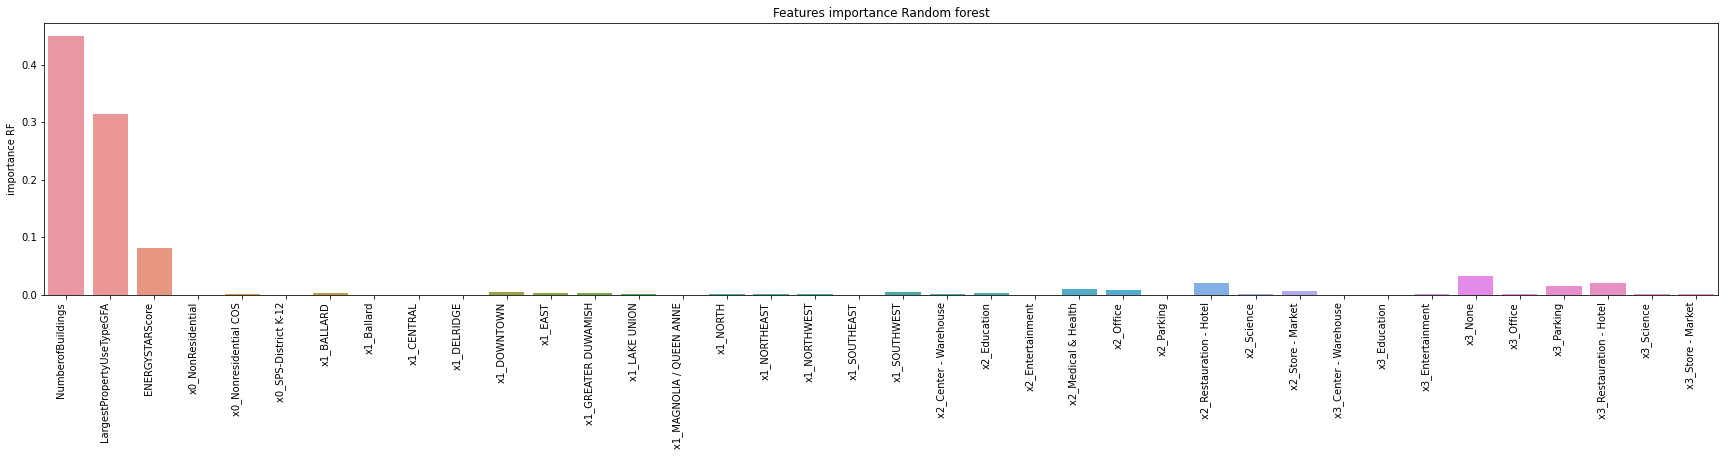

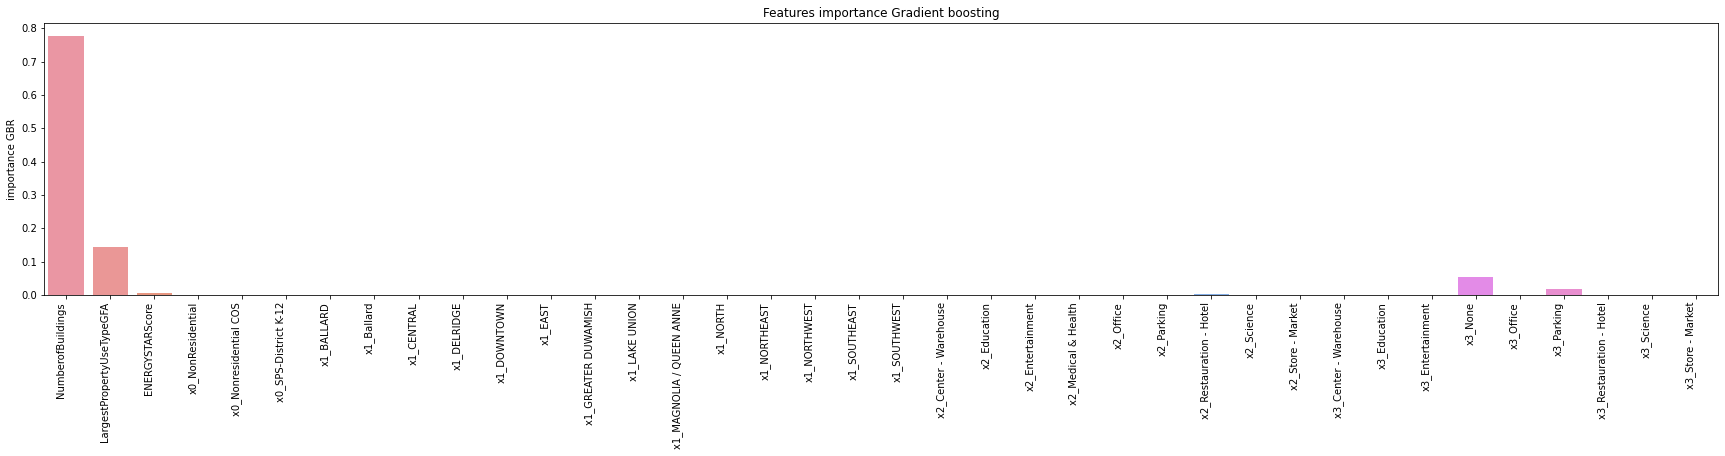

In [ ]:
plt.figure(figsize=(30,5))
sns.barplot(x = tab_with_ESS.index,
            y = tab_with_ESS['importance RF']).set_xticklabels(labels = tab_with_ESS.index,
                      rotation=90,
                    horizontalalignment='right',
                    size=10,
                    )
plt.title('Features importance Random forest')
plt.show()

plt.figure(figsize=(30,5))
sns.barplot(x = tab_with_ESS2.index,
            y = tab_with_ESS2['importance GBR']).set_xticklabels(labels = tab_with_ESS2.index,
                      rotation=90,
                    horizontalalignment='right',
                    size=10,
                    )
plt.title('Features importance Gradient boosting')
plt.show()

**Features importances avec le SHAPE**


In [ ]:
#Modèle d'entrainement

modelRandom_with_ESS = best_params_RandomForestRegressor_with_ESS
#modelRandom_with_ESS.fit(xtrain_with_ESS, ytrain_with_ESS)

modelGBR_with_ESS = best_params_GradientBoostingRegressor_with_ESS
#modelGBR_with_ESS.fit(xtrain_with_ESS, ytrain_with_ESS)

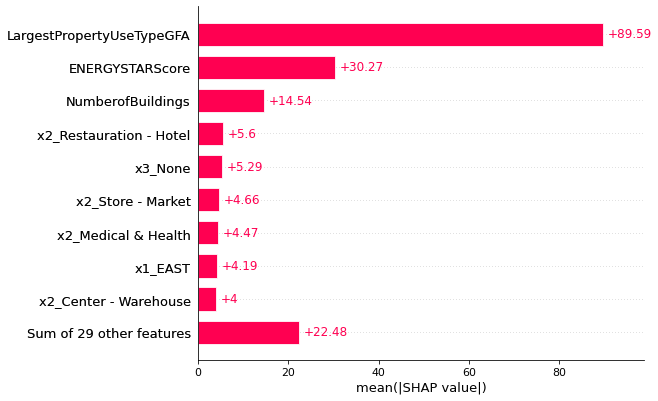

In [ ]:
random_explainer_with_ESS = shap.TreeExplainer(modelRandom_with_ESS, xtrain_with_ESS) #Radom forest
gradient_explainer_with_ESS = shap.TreeExplainer(modelGBR_with_ESS, xtrain_with_ESS) #Gradient boosting

shap_random_value_with_ESS = random_explainer_with_ESS(xtrain_with_ESS, check_additivity=False)
shap_gradient_value_with_ESS = gradient_explainer_with_ESS(xtrain_with_ESS, check_additivity=False)

shap.plots.bar(shap_random_value_with_ESS)

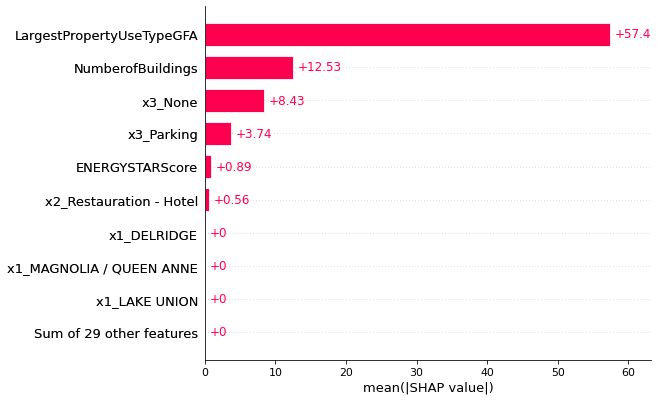

In [ ]:
shap.plots.bar(shap_gradient_value_with_ESS)

# Etape 4: Comparaison des modèles

Mean Absolute Error (MAE) tells us the average error in units of y , the predicted feature. A value of 0 indicates a perfect fit. 

Root Mean Square Error (RMSE) indicates the average error in units of y , the predicted feature, but penalizes larger errors more severely than MAE. A value of 0 indicates a perfect fit. 

R-squared (R2 ) tells us the degree to which the model explains the variance in the data. In other words how much better it is than just predicting the mean. 

A value of 1 indicates a perfect fit.

A value of 0 indicates a model no better than the mean. 

A value less than 0 indicates a model worse than just predicting the mean.

##Performance de la modélisation sans Energystarscore

### Performance des modèles par défaut

In [ ]:
defaultModel_Performance

,Score_train_R2,Score_train_MAE,Score_train_RMSE,Score_test_R2,Score_test_MAE,Score_test_RMSE
KNN Regressor,0.366759,87.3458,290.599153,0.504768,98.079883,291.811154
Dummy Regressor,0.0,139.48425,365.182321,-0.000495,163.791464,414.767666
Lasso,0.582612,117.3219,235.928215,0.755097,92.464019,205.20829
Ridge,0.587768,118.586341,234.466326,0.76104,98.323573,202.7031
Decision Tree,1.0,0.0,0.0,0.54716,117.650291,279.042261
SVR,-0.037382,111.774694,371.945279,-0.03636,125.470067,422.13648
ElasticNet,0.464648,111.384023,267.19575,0.64075,105.454855,248.5399
Random Forest Regressor,0.861879,41.059664,135.718659,0.687188,88.166949,231.920684
Gradient Boosting Regressor,0.973746,42.831187,59.170248,0.642929,99.171021,247.784775
Stochastic Gradient Descent Regressor (SGDRegressor),0.580504,116.444517,236.523254,0.749913,94.659321,207.368486


Comparaison des performances des modèles par défaut


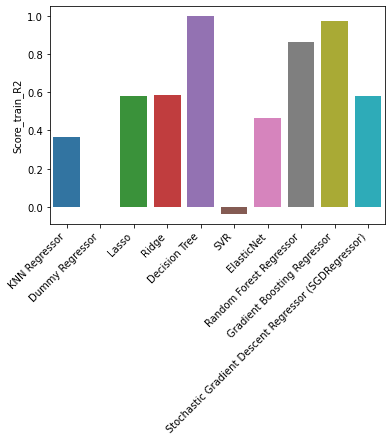

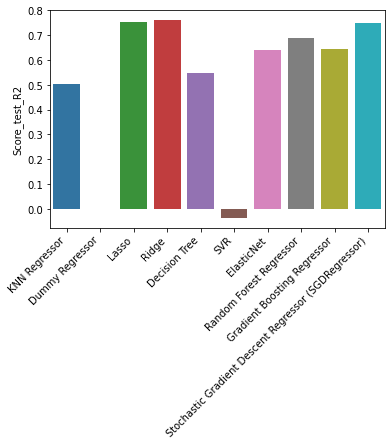

In [ ]:
print('Comparaison des performances des modèles par défaut')
sns.barplot(x = defaultModel_Performance.index,
            y = defaultModel_Performance['Score_train_R2']).set_xticklabels(labels = defaultModel_Performance.index, 
                      rotation=45,
                    horizontalalignment='right',
                    size=10,
                    )
plt.show()
sns.barplot(x = defaultModel_Performance.index,
            y = defaultModel_Performance['Score_test_R2']).set_xticklabels(labels = defaultModel_Performance.index, 
                      rotation=45,
                    horizontalalignment='right',
                    size=10,
                    )
plt.show()

On constate que nos modèle sont bien entrainé sur les données d'entraiment mais lorsqu'il recoivent les ouveau données de test, les performances sont très peu fiable

###Performance des modèles optimisés

In [ ]:
paramModel_Performance

,Score_train_R2,Score_train_MAE,Score_train_RMSE,Score_test_R2,Score_test_MAE,Score_test_RMSE
KNN Regressor,0.432699,83.440483,275.053114,0.493915,101.338505,294.991365
Dummy Regressor,-0.023318,117.611567,369.415393,-0.024563,134.880272,419.726808
Lasso,0.5826,117.399191,235.931576,0.755351,92.714474,205.101712
Ridge,0.587291,118.732145,234.60203,0.760646,98.19451,202.869946
Decision Tree,1.0,0.0,0.0,0.41626,119.097961,316.815934
SVR,-0.037399,111.774382,371.948398,-0.036375,125.466921,422.139536
ElasticNet,0.464633,111.38347,267.199433,0.640728,105.457571,248.547201
Random Forest Regressor,0.810058,43.463682,159.154881,0.719977,89.27701,219.429028
Gradient Boosting Regressor,0.806167,89.265639,160.776732,0.650912,106.378763,244.999438
Stochastic Gradient Descent Regressor (SGDRegressor),0.582272,117.170148,236.024336,0.753926,95.024446,205.69817


Comparaison des performances des modèles paramétrés


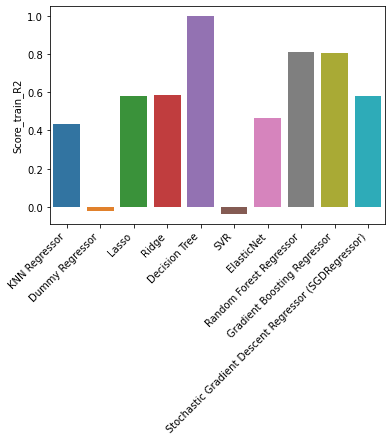

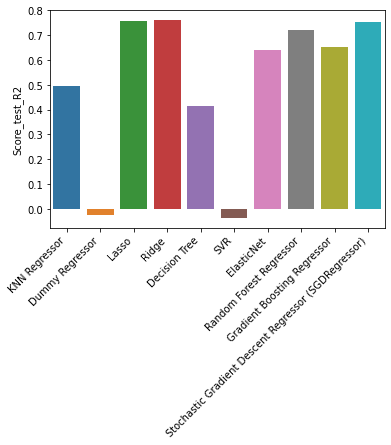

In [ ]:
print('Comparaison des performances des modèles paramétrés')
sns.barplot(x = paramModel_Performance.index,
            y = paramModel_Performance['Score_train_R2']).set_xticklabels(labels = paramModel_Performance.index, 
                      rotation=45,
                    horizontalalignment='right',
                    size=10
                    )
plt.show()
sns.barplot(x = paramModel_Performance.index,
            y = paramModel_Performance['Score_test_R2']).set_xticklabels(labels = paramModel_Performance.index, 
                      rotation=45,
                    horizontalalignment='right',
                    size=10
                    )
plt.show()

##Intêret du Enerystarscore

### Performance des modèles par défaut avec Energystar score

In [ ]:
defaultModel_Performance_with_ESS

,Score_train_R2,Score_train_MAE,Score_train_RMSE,Score_test_R2,Score_test_MAE,Score_test_RMSE
KNN Regressor,0.374502,89.642317,288.816881,0.516448,102.552544,288.349364
Dummy Regressor,0.0,139.48425,365.182321,-0.000495,163.791464,414.767666
Lasso,0.595017,118.527353,232.395612,0.767392,89.237687,199.99074
Ridge,0.599919,119.756737,230.984971,0.774619,93.966824,196.859238
Decision Tree,1.0,0.0,0.0,0.416699,119.741068,316.696941
SVR,-0.037561,111.980106,371.977346,-0.036405,125.817098,422.145585
ElasticNet,0.47868,109.077315,263.670789,0.651096,98.713272,244.934593
Random Forest Regressor,0.82923,40.787969,150.909142,0.77617,80.933077,196.180886
Gradient Boosting Regressor,0.982749,35.071546,47.964596,0.693192,92.592956,229.684149
Stochastic Gradient Descent Regressor (SGDRegressor),0.589147,116.456174,234.073894,0.762218,88.709068,202.202857


Comparaison des performances des modèles par défaut avec Energystar score


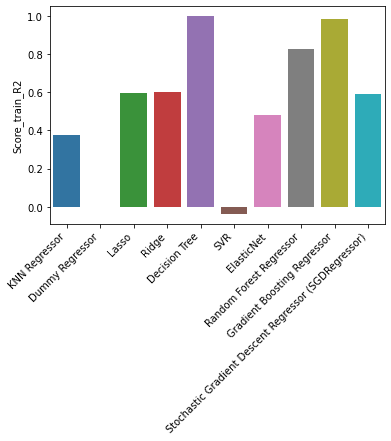

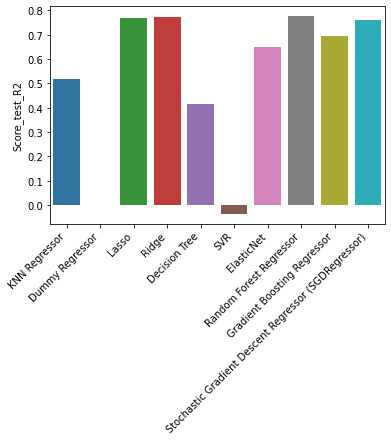

In [ ]:
print('Comparaison des performances des modèles par défaut avec Energystar score')
sns.barplot(x = defaultModel_Performance_with_ESS.index,
            y = defaultModel_Performance_with_ESS['Score_train_R2']).set_xticklabels(labels = defaultModel_Performance_with_ESS.index, 
                      rotation=45,
                    horizontalalignment='right',
                    size=10,
                    )
plt.show()
sns.barplot(x = defaultModel_Performance_with_ESS.index,
            y = defaultModel_Performance_with_ESS['Score_test_R2']).set_xticklabels(labels = defaultModel_Performance_with_ESS.index, 
                      rotation=45,
                    horizontalalignment='right',
                    size=10,
                    )
plt.show()

On constate que nos modèle sont bien entrainé sur les données d'entraiment mais lorsqu'il recoivent les ouveau données de test, les performances sont très peu fiable

###Performance des modèles paramétrés

In [ ]:
paramModel_Performance_with_ESS

,Score_train_R2,Score_train_MAE,Score_train_RMSE,Score_test_R2,Score_test_MAE,Score_test_RMSE
KNN Regressor,0.41631,84.57765,278.997814,0.520168,101.584155,287.238098
Dummy Regressor,-0.023318,117.611567,369.415393,-0.024563,134.880272,419.726808
Lasso,0.595114,118.653359,232.367984,0.767271,89.458151,200.042589
Ridge,0.599428,119.840031,231.126523,0.774214,93.908533,197.036321
Decision Tree,1.0,0.0,0.0,0.487831,111.570291,296.759106
SVR,-0.038634,111.986819,372.169616,-0.037341,125.68603,422.336115
ElasticNet,0.47868,109.077315,263.670789,0.651096,98.713272,244.934593
Random Forest Regressor,0.831007,43.036309,150.121877,0.781051,80.337068,194.030162
Gradient Boosting Regressor,0.806167,89.265639,160.776732,0.650912,106.378763,244.999438
Stochastic Gradient Descent Regressor (SGDRegressor),0.594072,117.987711,232.666843,0.767943,90.262681,199.753838


Comparaison des performances des modèles optimisés avec Energystarscore


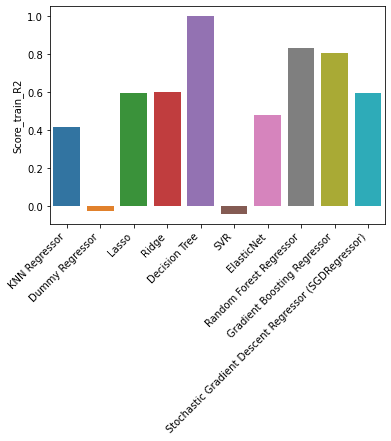

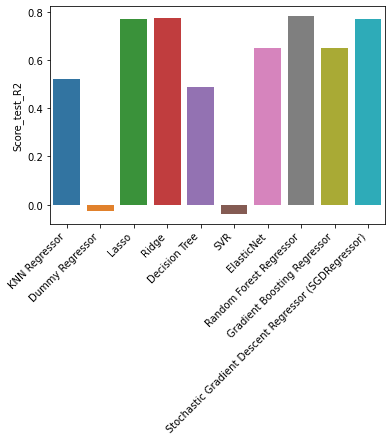

In [ ]:
print('Comparaison des performances des modèles optimisés avec Energystarscore')
sns.barplot(x = paramModel_Performance_with_ESS.index,
            y = paramModel_Performance_with_ESS['Score_train_R2']).set_xticklabels(labels = paramModel_Performance_with_ESS.index, 
                      rotation=45,
                    horizontalalignment='right',
                    size=10
                    )
plt.show()
sns.barplot(x = paramModel_Performance_with_ESS.index,
            y = paramModel_Performance_with_ESS['Score_test_R2']).set_xticklabels(labels = paramModel_Performance_with_ESS.index, 
                      rotation=45,
                    horizontalalignment='right',
                    size=10
                    )
plt.show()

#CONSLUSION

Le Random Forest(n_estimators = 50 , random_state=10) est le meilleurs modèle de prédictions ici

ON constate que l'energystar score impact un peu les performances des modèles en ce qui concerne l'exactitude des prédictions 